# 🧬 NTv3 Post-Trained Inference on Human Genomic Windows

This notebook demonstrates how to use the **NTv3 post-trained model** to predict functional genomics tracks and genomic element annotations from DNA sequences.

> 📝 **Note for Google Colab users:** This notebook is compatible with Colab! For faster inference, make sure to enable GPU: Runtime → Change runtime type → GPU (T4 or better recommended).

## 📋 Overview

Given a genomic window from the **human genome (hg38)**, the model performs inference and generates:

- **Functional tracks** (`bigwig_tracks_logits`): Predictions for thousands of functional genomics tracks (e.g., ChIP-seq, RNA-seq, DNase-seq) across multiple cell types and conditions
- **Genomic element annotations** (`bed_tracks_logits`): Classification predictions for genomic elements such as genes, exons, introns, splice sites, promoters, enhancers, and more
- **Masked Language Model logits** (`logits`): Standard transformer language model outputs

> 💡 **Note:** Functional tracks and genomic element annotations are predicted only for the center 37.5% of the input sequence, where the model is more confident due to having full context on both sides.

## 📚 Notebook Structure

1. **Setup**: Install dependencies and define the genomic window of interest
2. **Data Loading**: Download and fetch the chromosome sequence from UCSC
3. **Model Loading**: Load the NTv3 post-trained model and tokenizers
4. **Inference**: Run the model on the genomic window to generate predictions
5. **Visualization**: Plot selected functional tracks and genomic element predictions together in a unified view

## ✨ Additional Features

- Supports multiple NTv3 post-trained models
- Supports the 24 species that NTv3 was post-trained on

## 0) 📦 Imports + setup

In [ ]:
# Login to HuggingFace (required for gated models)
from huggingface_hub import login
login()

In [1]:
# Install dependencies
!pip -q install "transformers>=4.55" "huggingface_hub>=0.23" safetensors torch pyfaidx requests seaborn matplotlib

In [2]:
import os
import re
import math

import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer

from pyfaidx import Fasta
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if (device == "cuda" and torch.cuda.get_device_capability(0)[0] >= 8) else torch.float16
print("device:", device, "dtype:", dtype)

## 1) 📦 Configuration

Set your NTv3 model and genomic window here

In [4]:
# -----------------------------
# User inputs
# -----------------------------
model_name = "InstaDeepAI/NTv3_100M_post" # options: "InstaDeepAI/NTv3_100M_post" or "InstaDeepAI/NTv3_650M_post"

# Example window from a given species (edit these) - needs to be multiple of 128 due to the model downsampling
species = "human"  # will use for condition the model on species
assembly = "hg38"  # will use for fetching the chromosome sequence
chrom = "chr19"
start = 6_700_000
end   = 6_732_768
# Limiting to 32kb to work on Google Colab T4 GPU -> increase up to 1 million nucleotides if you have a better GPU

# Optional
HF_TOKEN = os.getenv("HF_TOKEN", None)

## 2) 📥 Fetch chromosome sequence for the chosen window

In [5]:
# Get the sequence from the UCSC API
url = f"https://api.genome.ucsc.edu/getData/sequence?genome={assembly};chrom={chrom};start={start};end={end}"
seq = requests.get(url).json()["dna"].upper()
print(f"Original sequence length: {len(seq)}")

# Crop to multiple of 128 (the pipeline will crop again, but this is a no-op once divisible)
seq = seq[:int(len(seq) // 128) * 128]
print(f"Cropped sequence length: {len(seq)}, {len(seq) / 128} transformer tokens")

Original sequence length: 32768
Cropped sequence length: 32768, 256.0 transformer tokens


## 3) 🤖 Load NTv3 model + tokenizers

In [6]:
# Load model
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Set model to evaluation mode
model.eval()

NTv3PostTrained(
  (core): NTv3PostTrainedCore(
    (embed_layer): Embedding(11, 16)
    (stem): Stem(
      (conv): Conv1d(16, 768, kernel_size=(15,), stride=(1,), padding=same)
    )
    (conv_tower_blocks): ModuleList(
      (0-6): 7 x ConditionedConvTowerBlock(
        (conv): AdaptiveConvBlock(
          (conv): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=same)
          (layer_norm): AdaptiveLayerNorm(
            (np.int64(768),), eps=1e-05, elementwise_affine=True
            (modulation_layers): ModuleList(
              (0): Linear(in_features=16, out_features=1536, bias=True)
            )
          )
        )
        (res_conv): AdaptiveResidualConvBlock(
          (conv_block): AdaptiveConvBlock(
            (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
            (layer_norm): AdaptiveLayerNorm(
              (np.int64(768),), eps=1e-05, elementwise_affine=True
              (modulation_layers): ModuleList(
                (0): Linear

In [7]:
# Inspect output functional tracks
cfg = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
bigwig_names = cfg.bigwigs_per_species[species]
print(f"{len(bigwig_names)} functional tracks for {species}. First 10:", bigwig_names[:10])

# Inspect output genomic elements
bed_element_names = cfg.bed_elements_names
print("Genomic elements predicted:", bed_element_names)

7362 functional tracks for human. First 10: ['kai1', 'kai2', 'kai3', 'kai4', 'kai5', 'kai6', 'kai7', 'kai8', 'kai10', 'kai9']
Genomic elements predicted: ['protein_coding_gene', 'lncRNA', 'exon', 'intron', 'splice_donor', 'splice_acceptor', 'CTCF-bound', 'polyA_signal', 'enhancer_Tissue_specific', 'enhancer_Tissue_invariant', 'promoter_Tissue_specific', 'promoter_Tissue_invariant', '5UTR+', '5UTR-', '3UTR+', '3UTR-', 'skipped_exon', 'always_on_exon', 'start_codon', 'stop_codon', 'ORF']


## 4) ⚡ Tokenize the window and run inference

We pass:

- `input_ids`: tokenized DNA window
- `species_ids`: species tokens (`human`)

Outputs include:

- `bigwig_tracks_logits`: per-position track predictions
- `bed_tracks_logits`: per-position classification logits for BED elements
- `logits`: masked LM logits

In [8]:
# Tokenize DNA sequence (single example batch)
batch = tokenizer([seq], add_special_tokens=False, return_tensors="pt")
input_ids = batch["input_ids"].to(device)

# Condition tokens (e.g., species)
species = 'human'
species_ids = model.encode_species(species).to(device)

# Run inference
out = model(
    input_ids=input_ids,
    species_ids=species_ids,
)

# 7k human tracks over 37.5 % center region of the input sequence
print("bigwig_tracks_logits:", tuple(out["bigwig_tracks_logits"].shape))
# Location of 21 genomic elements over 37.5 % center region of the input sequence
print("bed_tracks_logits:", tuple(out["bed_tracks_logits"].shape))
# Language model logits for whole sequence over vocabulary
print("language model logits:", tuple(out["logits"].shape))

bigwig_tracks_logits: (1, 12288, 7362)
bed_tracks_logits: (1, 12288, 21, 2)
language model logits: (1, 32768, 11)


## 5) 📊 Plot functional tracks and genome annotation predictions

This plots track probabilities for selected functional tracks and genomic elements.

For functional tracks we plot logits directly here. If you have a calibrated mapping (e.g., sigmoid/softplus), apply it before plotting.

Genome annotation tracks have a final dimension for classes (`[neg, pos]`). Here, we:
- convert logits to probabilities using softmax
- extract the positive-class probability for selected elements
- plot them as continuous tracks

In [9]:
def plot_tracks(tracks, start, end, height=1.0):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(start, end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(f"{chrom}:{start}-{end} ({assembly})")
    plt.tight_layout()


In [10]:
### 🎯 Select functional tracks to plot
tracks_to_plot = {
    "K562 RNA-seq": "ENCSR056HPM",
    "K562 DNAse": "ENCSR921NMD",
    "K562 H3k4me3": "ENCSR000DWD",
    "K562 CTCF": "ENCSR000AKO",
    "HepG2 RNA-seq": "ENCSR561FEE_P",
    "HepG2 DNAse": "ENCSR000EJV",
    "HepG2 H3k4me3": "ENCSR000AMP",
    "HepG2 CTCF": "ENCSR000BIE",
}

# Check that all tracks are available
missing_tracks = [v for k,v in tracks_to_plot.items() if v not in bigwig_names]
if missing_tracks:
    raise ValueError(
        f"The following tracks are not available in bigwig_names: {missing_tracks}\n"
        f"Available tracks: {bigwig_names}"
    )
    
### 🧬 Select genomic elements to plot
elements_to_plot = [
    "protein_coding_gene",
    "exon",
    "intron",
    "splice_donor",
    "splice_acceptor",
]

# Check that all elements are available
missing_elements = [elem for elem in elements_to_plot if elem not in bed_element_names]
if missing_elements:
    raise ValueError(
        f"The following elements are not available in bed_element_names: {missing_elements}\n"
        f"Available elements: {bed_element_names}"
    )

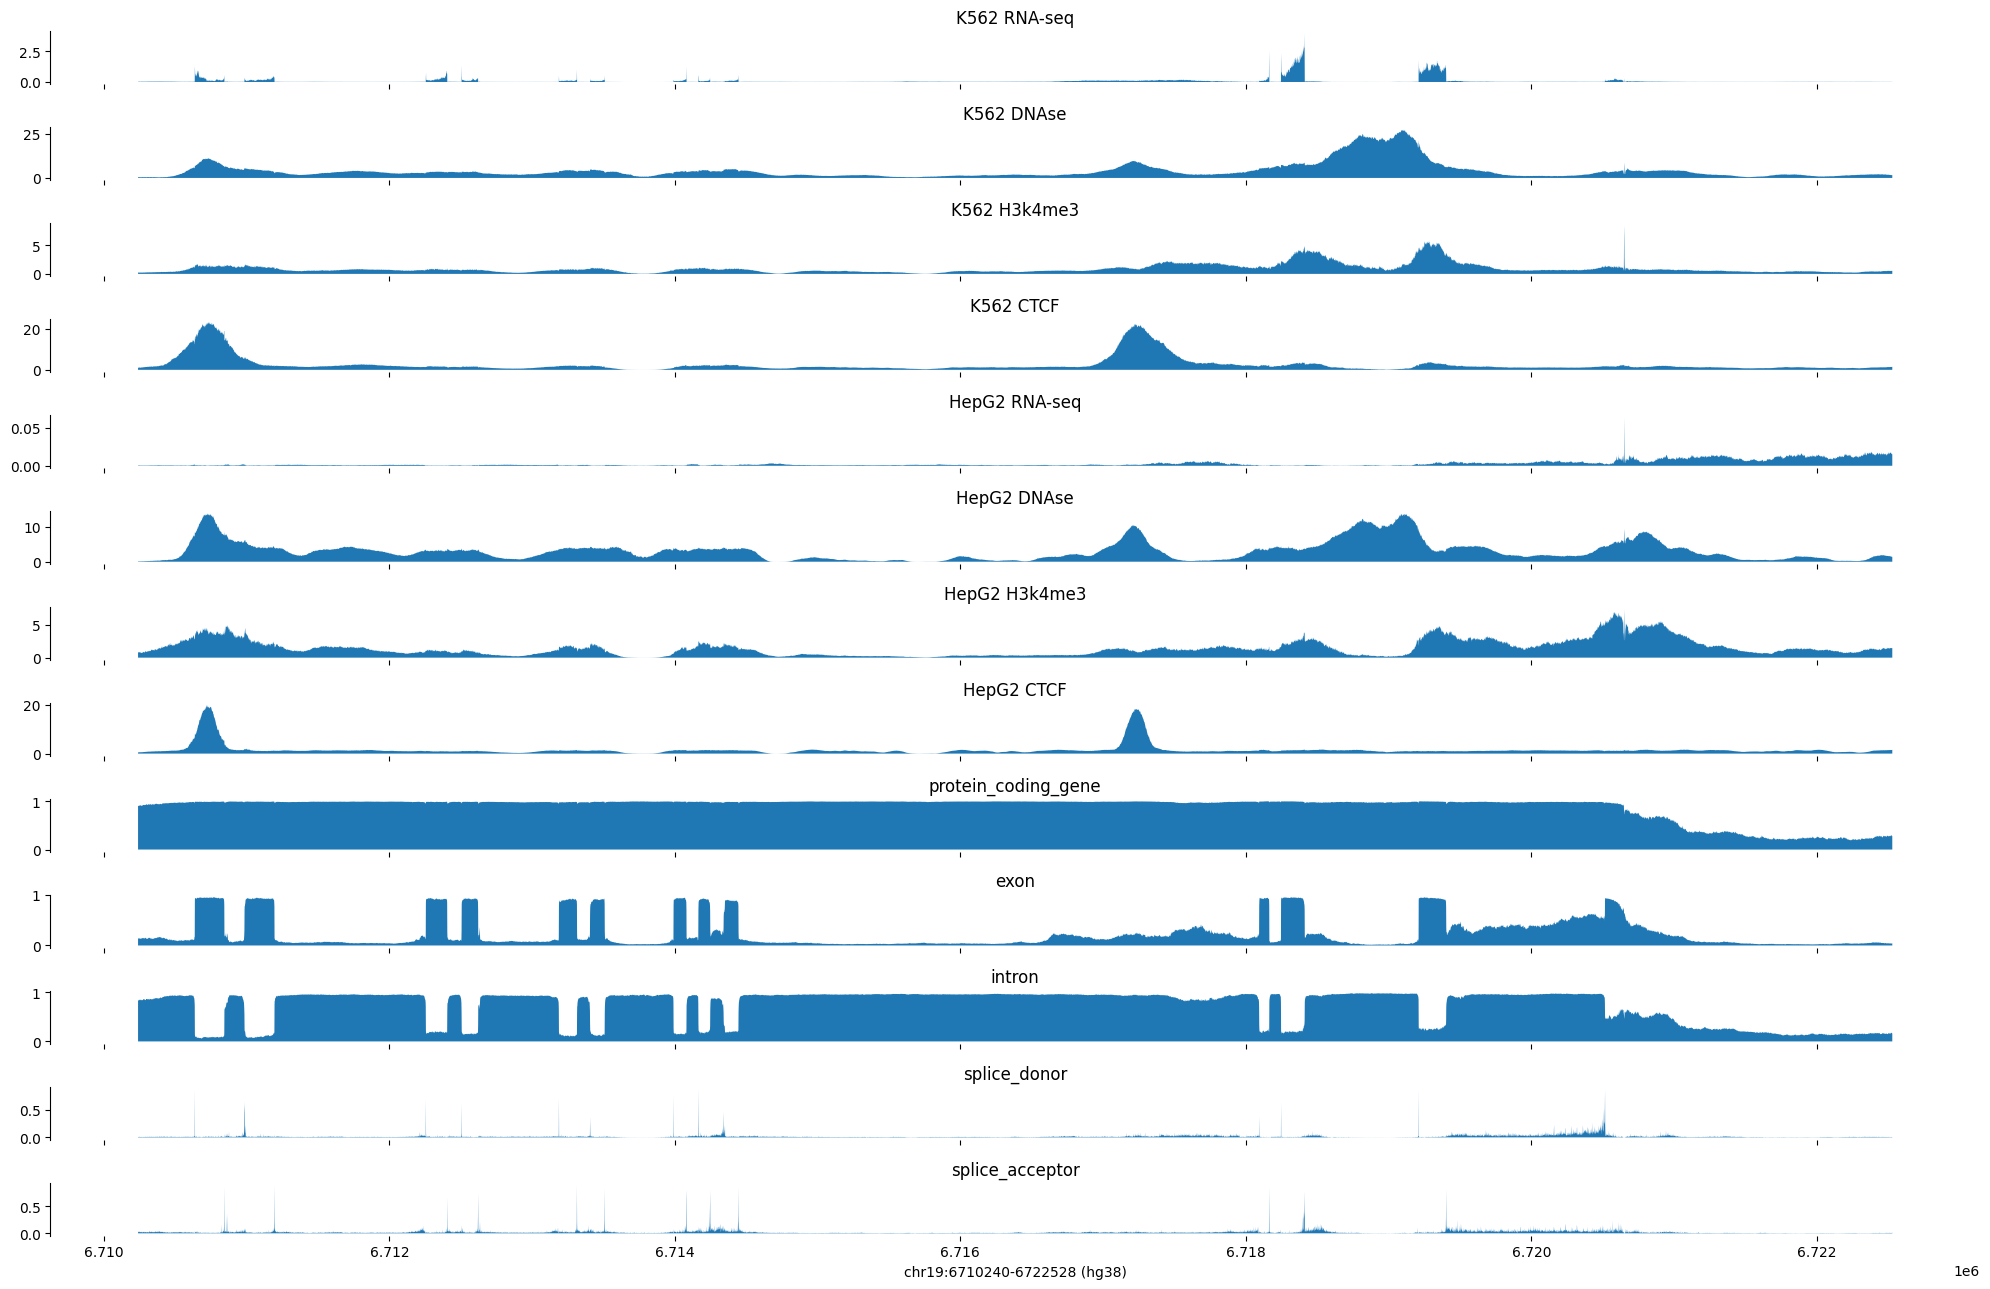

In [11]:
# Extract functional tracks for selected tracks
bigwig = out["bigwig_tracks_logits"].detach().float().cpu().numpy()[0]  # shape: (sequence length, number of tracks)
bigwig_tracks = {}  # track_name -> logits track
for track_name, track_id in tracks_to_plot.items():
    track_idx = bigwig_names.index(track_id)
    bigwig_tracks[track_name] = bigwig[:, track_idx]

# Genomic element predictions
bed_logits = out["bed_tracks_logits"].detach().float().cpu().numpy()[0] # shape: (sequence length, number of elements, 2 classes)
# Convert annotation logits to probabilities using softmax
exp = np.exp(bed_logits - bed_logits.max(axis=-1, keepdims=True))
probs = exp / exp.sum(axis=-1, keepdims=True)

# Extract positive class probabilities (index 1) for selected elements
bed_probs = {}  # element_name -> probability track
for element_name in elements_to_plot:
    if element_name in bed_element_names:
        element_idx = bed_element_names.index(element_name)
        bed_probs[element_name] = probs[:, element_idx, 1]  # positive class probability

# Model predicts for middle 37.5% of input sequence
# So predictions start at: start + (window_len - window_len * 0.375) / 2 = start + window_len * 0.3125
window_len = end - start
prediction_start = start + int(window_len * 0.3125)
prediction_end = prediction_start + int(window_len * 0.375)
x = np.arange(prediction_start, prediction_end)

# Combine bigwig and bed tracks
all_tracks = {**bigwig_tracks, **bed_probs}

# Plot all tracks together
plot_tracks(all_tracks, prediction_start, prediction_end)
plt.show()
